In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas
from pandas_profiling import ProfileReport
from scipy.stats import ttest_ind

from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier,GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import chi2, f_classif, SelectKBest, mutual_info_classif, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, train_test_split
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold

from sklearn.naive_bayes import GaussianNB
# from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC

In [2]:
df = pd.read_csv("./Data/processed_panel_1and3.csv")
df.head()

PROTEINS = df.iloc[:,1:df.columns.get_loc("Age")].columns.to_list()
CLINICAL = ['Age', 'Gender', 'Hypertension', 'Hyperchol',
       'Diabetes', 'Renal Insufficiency', 'Dialysis', 'Smoking Hx',
       'Congestive heart failure', 'Cornary artery disease', 'Stroke/TIA',
       'statin', 'ACEi/ARB', 'B-bl', 'CCB', 'HCTZ, Lasix', 'Insulin',
       'oral hypoglyc']
TARGET = ["hasPAD"]

## Clinical

Data has missing values, first step is to look at those

In [3]:
df[[col for col in CLINICAL if col not in ("Age")]].apply(lambda x: pd.value_counts(x,dropna=False))

,Gender,Hypertension,Hyperchol,Diabetes,Renal Insufficiency,Dialysis,Smoking Hx,Congestive heart failure,Cornary artery disease,Stroke/TIA,statin,ACEi/ARB,B-bl,CCB,"HCTZ, Lasix",Insulin,oral hypoglyc
0.0,158.0,108.0,104.0,291.0,447.0,459.0,124,434.0,285.0,365.0,89.0,176.0,274.0,325.0,375.0,388.0,315.0
1.0,301.0,350.0,354.0,169.0,12.0,NaN,237,21.0,169.0,78.0,345.0,257.0,158.0,108.0,57.0,43.0,112.0
2.0,NaN,NaN,NaN,NaN,NaN,NaN,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,2.0,3.0,3.0,1.0,2.0,2.0,5,6.0,7.0,18.0,27.0,28.0,29.0,28.0,29.0,30.0,34.0


In [4]:
df[CLINICAL].dropna().shape

(406, 18)

In [5]:
df.groupby(TARGET)["Stroke/TIA"].mean()

hasPAD
0    0.106250
1    0.215548
Name: Stroke/TIA, dtype: float64

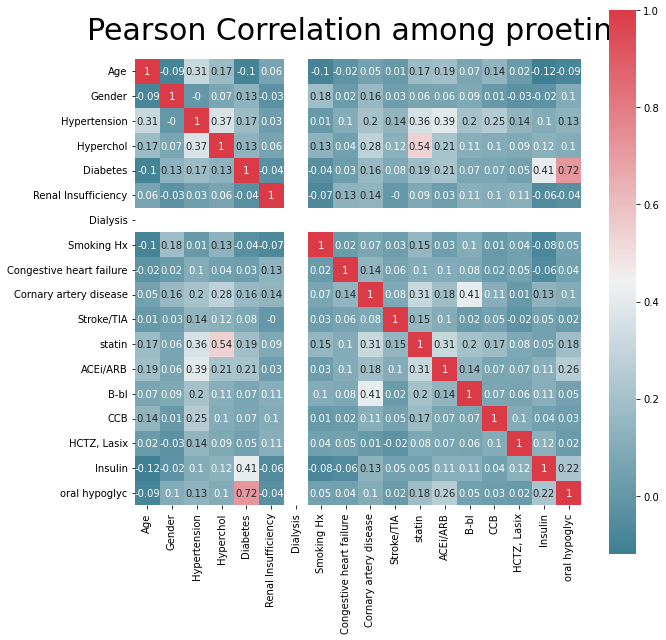

In [6]:
###clinical variables
def correlation_plot(X):
    fig, ax = plt.subplots(figsize=(10, 10))
    corr = X.corr().round(2)
    ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
                square=True, ax=ax, annot=True, annot_kws={"fontsize":10})
    ax.set_title("Pearson Correlation among proetins", fontsize = 30, pad = 20)
    plt.show()
    # plt.savefig('./reports/hq.png', format='png', dpi=300)

correlation_plot(df[CLINICAL].dropna())

In [7]:
# Let's remove Dialysis, oral hypoglyc -- cutoff: 0.6
df_clinic = df[[col for col in CLINICAL if col not in ("Dialysis", 'oral hypoglyc')]]

na_count = df_clinic.isna().sum()
print(f"max percentage of missing among clinical vars = {(na_count / df.shape[0] * 100).max():.2f}")
##All missing is less than 6 percent -- impute with mod

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy= 'most_frequent')

X = imputer.fit_transform(df_clinic)
df_clinic = pd.DataFrame(X, columns=df_clinic.columns)

print(f"# missing values = {df_clinic.isna().sum().sum()} \ndf_clinic shape = {df_clinic.shape}")

max percentage of missing among clinical vars = 6.51
# missing values = 0 
df_clinic shape = (461, 16)


In [8]:
#simple LR
## simple logistic regression on file
X = df_clinic
y = df[TARGET].squeeze()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify= y,
     train_size=0.7, random_state=42)
model_LR = LogisticRegression( solver='liblinear',random_state=42)
model_LR.fit(X_train, y_train)

y_pred = model_LR.predict(X_test)
y_pred_proba = model_LR.predict_proba(X_test)[:,1]
print(*[metrics.accuracy_score(y_test, y_pred),
metrics.roc_auc_score(y_test, y_pred_proba)], sep = "\n")

0.7985611510791367
0.763370786516854


In [ ]:
met

In [69]:
#coefficients
pd.Series(model_LR.coef_.squeeze(), index= X.columns)

Age                         0.021749
Gender                     -0.397635
Hypertension                0.554071
Hyperchol                   0.031982
Diabetes                    1.033276
Renal Insufficiency         0.319557
Smoking Hx                  0.589199
Congestive heart failure    0.582543
Cornary artery disease      0.579820
Stroke/TIA                  0.519253
statin                      0.244593
ACEi/ARB                    0.180054
B-bl                       -0.025444
CCB                         0.201907
HCTZ, Lasix                -0.023475
Insulin                     0.058331
dtype: float64

In [70]:
xx = pd.concat([df_clinic, df[TARGET]], axis = 1)
# ratio = []
# for col in df_clinic.columns:
#     if col != "Age":
#         t = xx.groupby("hasPAD")[col].mean()
#         ratio.append(t[1] / t[0])
# ratio_series = pd.Series(ratio, index = df_clinic.columns[1:])

pval = []
for col in xx.columns[:-1]:
    grp1 = xx.loc[xx.hasPAD == 1, col]
    grp2 = xx.loc[xx.hasPAD == 0, col]
    # print("Protein {} has variance test p-value: {:.2f} ".format(protein, levene(grp1, grp2)[1]))
    pval.append(ttest_ind(grp1, grp2, equal_var=False)[1])

t_test = pd.DataFrame(pval, index=xx.columns[:-1], columns=["p_value"])
t_test["ttest_sig"] = (t_test["p_value"] < 0.05).astype(int)
t_test.round(8).sort_values("p_value")

,p_value,ttest_sig
Hypertension,0.000000e+00,1
Diabetes,1.000000e-08,1
statin,3.100000e-07,1
Age,7.000000e-07,1
ACEi/ARB,3.680000e-06,1
Hyperchol,2.256000e-05,1
Cornary artery disease,3.068000e-05,1
Smoking Hx,1.724100e-04,1
Congestive heart failure,1.771300e-03,1
Stroke/TIA,1.896530e-03,1


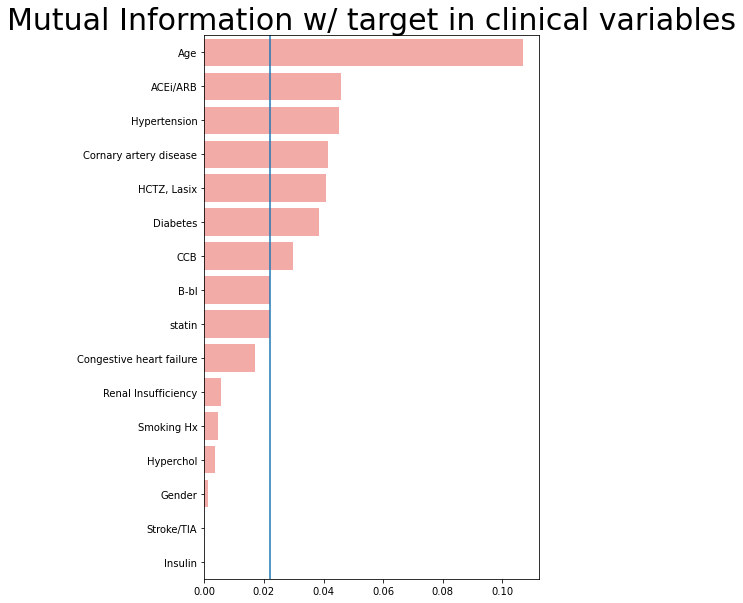

In [71]:
## Let's do Mutual Info too

discrete_mask = np.ones(xx.shape[1] - 1).astype(int)
for idx, col in enumerate(xx.iloc[:,:-1]):
    if len(xx[col].unique()) > 10 :
        discrete_mask[idx] = 0
mi = pd.Series(
    mutual_info_classif(xx.iloc[:,:-1], xx.iloc[:,-1], discrete_features=discrete_mask),
    index = xx.iloc[:,:-1].columns
).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(6, 10))
sns.set_color_codes("pastel")
fig = sns.barplot(x = mi.values, y = mi.index, color="r")
fig.set_title("Mutual Information w/ target in clinical variables", fontsize = 30)
fig.axvline(x=mi.median(), )
plt.show()

## Proteins

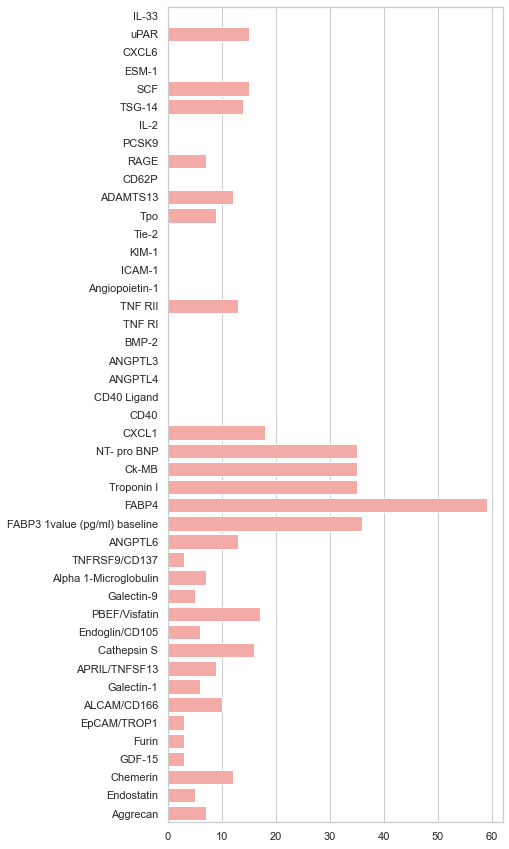

In [72]:
## missing value analysis on proteins

sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

prot_miss = df[PROTEINS].isna().sum()
# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x = prot_miss.values, y = prot_miss.index,
            label="Number of missing in protein vars", color="r")
plt.show()

In [73]:
print( "Number of proteins in each treshold of missing: ",
    (prot_miss < 10).sum(),
    (prot_miss < 20).sum(),
    (prot_miss < 60).sum(),
    sep= "\n"
)

# Let's go with less than 20 missing values and impute them to use in the model

print("Proteins excluded due to missing criteria - : \n", prot_miss[prot_miss > 20].index.tolist())

df_protein = df[PROTEINS].loc[:,prot_miss[prot_miss < 20].index]
na_count = df_protein.isna().sum()
print(f"max percentage of missing among protins = {(na_count / df.shape[0] * 100).max():.2f}")

imputer = SimpleImputer(strategy= 'mean')

X = imputer.fit_transform(df_protein)
df_protein = pd.DataFrame(X, columns=df_protein.columns)
print(df_protein.shape)


Number of proteins in each treshold of missing: 
29
40
45
Proteins excluded due to missing criteria - : 
 ['NT- pro BNP', 'Ck-MB', 'Troponin I', 'FABP4', 'FABP3 1value (pg/ml) baseline']
max percentage of missing among protins = 3.90
(461, 40)


# Feature Selection - Modeling


Let's use RFE first

In [75]:
df[TARGET].value_counts() #the problem is not imbalanced per se
# But focus could be on better recall (how much actual positives are captured)

hasPAD
1         295
0         166
dtype: int64

In [76]:
scaler = MinMaxScaler(feature_range= (0,1))
X_prot = scaler.fit_transform(df_protein)

X = pd.concat([pd.DataFrame(X_prot, columns= df_protein.columns), df_clinic], axis= 1)
y = df[TARGET].squeeze()


model_LR = LogisticRegression(solver='liblinear', random_state=42)


min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=model_LR,
    step=1,
    cv=StratifiedKFold(5),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LogisticRegression(random_state=42, solver='liblinear'),
      scoring='accuracy')

Optimal number of features : 24


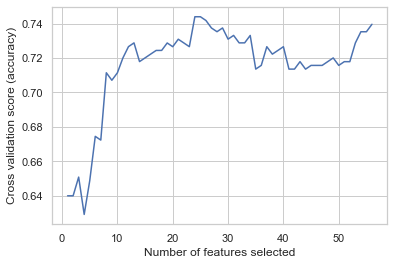

In [77]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
)
plt.show()

In [78]:
## now let's look at results
from sklearn.linear_model import LogisticRegressionCV


X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y,
    train_size=0.7, random_state=42)


print(rfecv.get_feature_names_out())

model_cv = LogisticRegressionCV(
    Cs=10,
    solver='liblinear',
    cv=StratifiedKFold(5),
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)
model_cv.fit(X_train, y_train) #train on all 56 vars with L2 regularization


['uPAR' 'CXCL6' 'TSG-14' 'RAGE' 'CD62P' 'ADAMTS13' 'Tpo' 'ICAM-1'
 'ANGPTL3' 'CXCL1' 'ANGPTL6' 'Alpha 1-Microglobulin' 'PBEF/Visfatin'
 'Cathepsin S' 'APRIL/TNFSF13' 'Furin' 'GDF-15' 'Endostatin' 'Aggrecan'
 'Hypertension' 'Diabetes' 'Renal Insufficiency' 'Smoking Hx'
 'Congestive heart failure']


LogisticRegressionCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                     n_jobs=-1, random_state=42, scoring='accuracy',
                     solver='liblinear')

In [79]:
y_pred = model_cv.predict(X_test)
y_pred_proba = model_cv.predict_proba(X_test)[:, 1]
print(*[metrics.accuracy_score(y_test, y_pred),
        metrics.roc_auc_score(y_test, y_pred_proba)], sep="\n")


0.762589928057554
0.7829213483146067


In [80]:
# now fit on selected features from rfecv
X_train, X_test, y_train, y_test = train_test_split(
    X[rfecv.get_feature_names_out()], y, stratify=y,
    train_size=0.7, random_state=42)

model_cv.fit(X_train, y_train) #train on all 56 vars with L2 regularization
y_pred = model_cv.predict(X_test)
y_pred_proba = model_cv.predict_proba(X_test)[:, 1]
print(*[metrics.accuracy_score(y_test, y_pred),
        metrics.roc_auc_score(y_test, y_pred_proba)], sep="\n")


0.7338129496402878
0.7889887640449438


In [81]:
coef_ranking = pd.Series(np.abs(model_cv.coef_.squeeze()), index = X_train.columns)
coef_ranking.sort_values(ascending = False)


#are not very consistent with the p values in t-test

CXCL6                       8.791130
Tpo                         7.259777
CXCL1                       7.112456
GDF-15                      6.604380
APRIL/TNFSF13               5.135433
CD62P                       4.257934
PBEF/Visfatin               3.857923
RAGE                        3.458923
ANGPTL6                     3.202515
TSG-14                      2.636967
Cathepsin S                 2.409300
ICAM-1                      2.381747
ADAMTS13                    2.312975
Endostatin                  2.040539
Furin                       1.618325
Hypertension                1.332515
Aggrecan                    1.180614
uPAR                        0.963629
Diabetes                    0.884304
Alpha 1-Microglobulin       0.778124
ANGPTL3                     0.752822
Smoking Hx                  0.718685
Congestive heart failure    0.188725
Renal Insufficiency         0.052665
dtype: float64

## Mutual Information

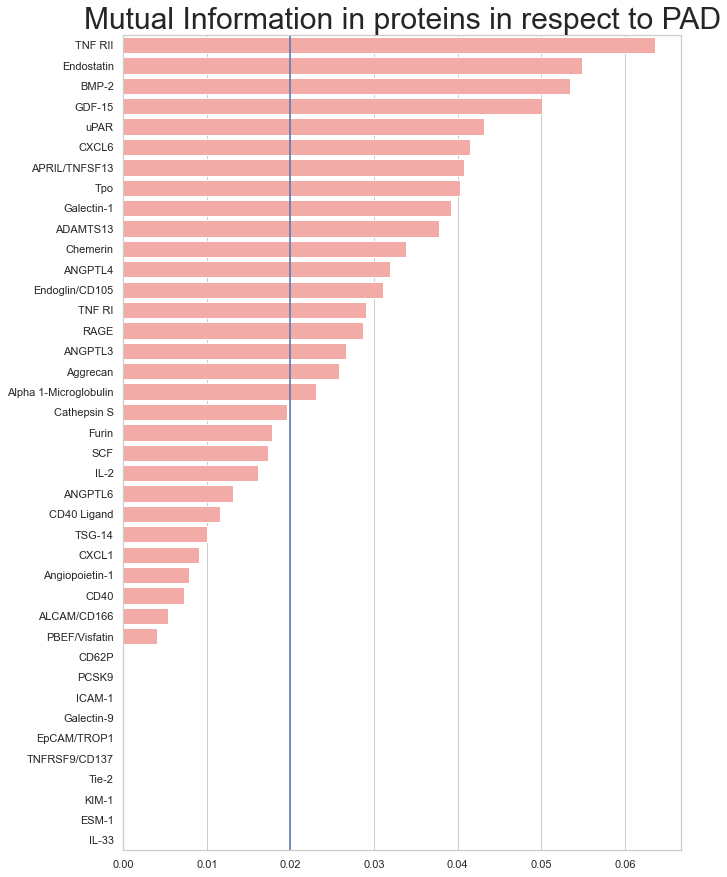

In [90]:
from sklearn.feature_selection import mutual_info_classif

MI = mutual_info_classif(pd.DataFrame(X_prot, columns= df_protein.columns),
 y,
discrete_features=False)

MI_prot = pd.Series(MI.squeeze(), index = df_protein.columns).sort_values(ascending = False)

f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
g = sns.barplot(x = MI_prot.values, y = MI_prot.index,
            label="Number of missing in protein vars", color="r")
g.set_title("Mutual Information in proteins in respect to PAD", fontsize = 30)
g.axvline(x=0.02)
plt.show()

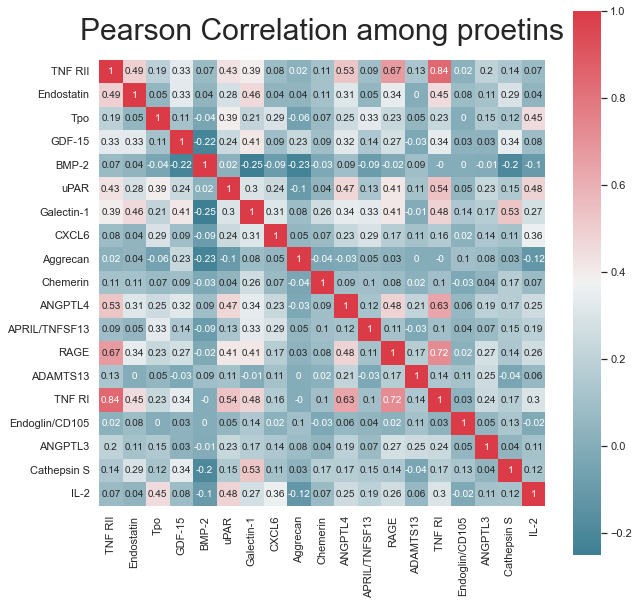

In [87]:
thr = 0.02
correlation_plot(X[MI_prot[MI_prot > thr].index])

In [ ]:
#Let's remove TNF RI and use the rest in the model to see what happens


# ML methods

## Random Forest - on selected features


In [110]:
# X
# y

# rfecv.get_feature_names_out()

In [161]:
mod_rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2)

# now fit on selected features from rfecv
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y,
    train_size=0.7, random_state=42)



mod_rf.fit(X_train, y_train,) 
y_pred = mod_rf.predict(X_test)
y_pred_proba = mod_rf.predict_proba(X_test)[:, 1]
print(*[metrics.accuracy_score(y_test, y_pred),
        metrics.roc_auc_score(y_test, y_pred_proba)], sep="\n")

0.7410071942446043
0.7231460674157304


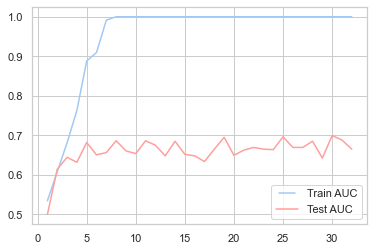

In [188]:
## check max_depth
max_depths = np.linspace(1, 32, 32, endpoint=True).astype(int)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1)
   rf.fit(X_train, y_train)
   train_pred = rf.predict(X_train)

   roc_auc = metrics.roc_auc_score(y_train, train_pred)
   train_results.append(roc_auc)
   y_pred = rf.predict(X_test)
   roc_auc = metrics.roc_auc_score(y_test, y_pred)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
# plt.ylabel(‘"AUC score"’)
# plt.xlabel(‘Tree depth’)
plt.show()

In [162]:
param_grid = {
    'n_estimators': [10, 20, 50, 100, 200, 300, 500],
    'max_features': [None, 'sqrt', 'log2', 0.3, 0.4, 0.5],
}

grid = GridSearchCV(estimator= RandomForestClassifier(), param_grid=param_grid, cv= StratifiedKFold(5), n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': [None, 'sqrt', 'log2', 0.3, 0.4, 0.5],
                         'n_estimators': [10, 20, 50, 100, 200, 300, 500]})

In [178]:
def plot_cv_results(cv_results, param_x, param_z, metric='mean_test_score'):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    fig, ax = plt.subplots(1, 1, figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, ci=99, n_boot=64, ax=ax)
    ax.set_title("CV Grid Search Results")
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.legend(title=param_z)
    return fig

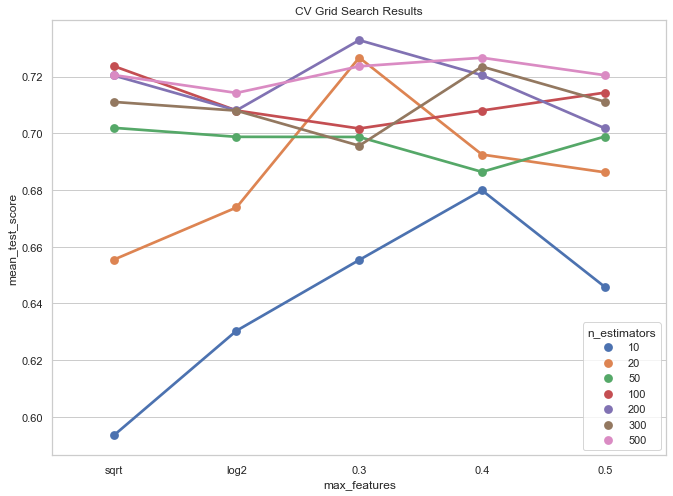

In [180]:
fig = plot_cv_results(grid.cv_results_, 'max_features', 'n_estimators')


In [198]:
grid.best_estimator_.score(X_test, y_test)

0.7338129496402878

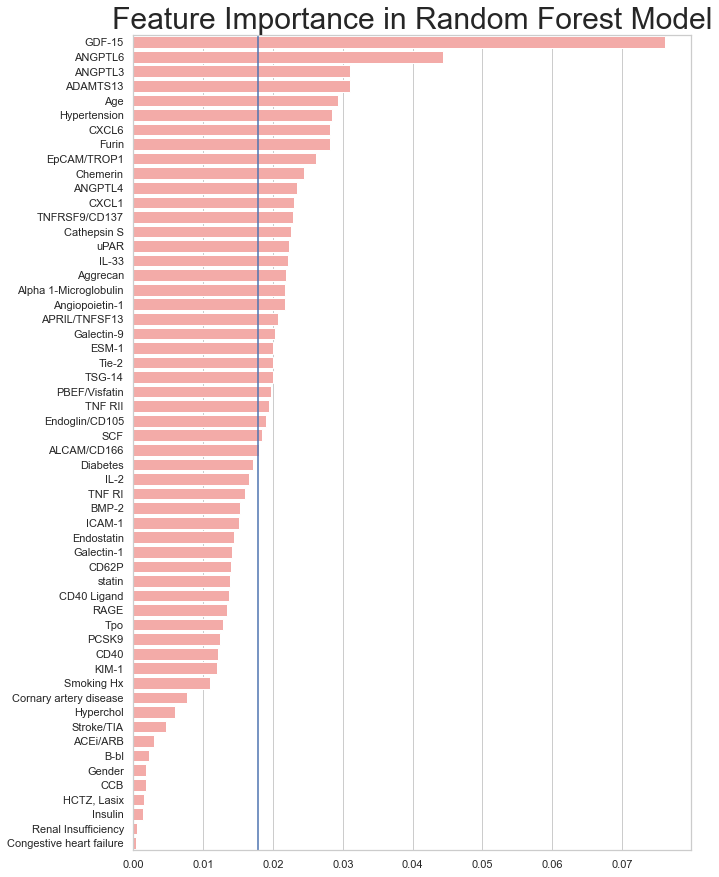

In [195]:

rfimp = pd.Series(grid.best_estimator_.feature_importances_,
 index=grid.best_estimator_.feature_names_in_).sort_values(ascending=False)

f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
fig = sns.barplot(x = rfimp.values, y = rfimp.index, color="r")
fig.set_title("Feature Importance in Random Forest Model", fontsize = 30)
fig.axvline(x=rfimp.mean(), )
plt.show()

In [199]:
grid.best_estimator_

RandomForestClassifier(max_features=0.3, n_estimators=200)

Optimal number of features : 45


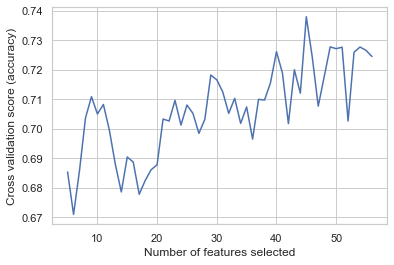

In [208]:
###feature selection using RF

min_features_to_select = 5  # Minimum number of features to consider
rfecv = RFECV(
    estimator=RandomForestClassifier(n_estimators=200),
    step=1,
    cv=StratifiedKFold(5),
    scoring="roc_auc",
    min_features_to_select=min_features_to_select,
    n_jobs=-1
)
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
)
plt.show()

In [215]:
[x for x in X.columns if x not in rfecv.get_feature_names_out()]

##not used mostly clincial vars

['Gender',
 'Hyperchol',
 'Renal Insufficiency',
 'Congestive heart failure',
 'Cornary artery disease',
 'Stroke/TIA',
 'ACEi/ARB',
 'B-bl',
 'CCB',
 'HCTZ, Lasix',
 'Insulin']

Optimal number of features : 12


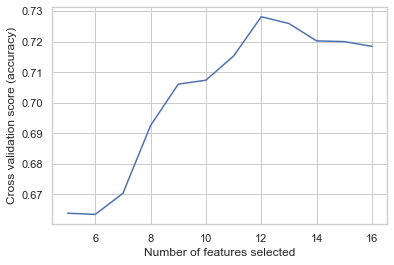

In [216]:
###feature selection using RF

min_features_to_select = 5  # Minimum number of features to consider
rfecv = RFECV(
    estimator=RandomForestClassifier(n_estimators=200),
    step=1,
    cv=StratifiedKFold(5),
    scoring="roc_auc",
    min_features_to_select=min_features_to_select,
    n_jobs=-1
)
rfecv.fit(df_clinic, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
)
plt.show()

In [218]:
[x for x in df_clinic.columns if x not in rfecv.get_feature_names_out()]


['Hyperchol', 'Renal Insufficiency', 'Congestive heart failure', 'Insulin']

In [220]:
rfecv.estimator

RandomForestClassifier(n_estimators=200)

In [ ]:
# rfimp = pd.Series(grid.best_estimator_.feature_importances_,
#  index=grid.best_estimator_.feature_names_in_).sort_values(ascending=False)

# f, ax = plt.subplots(figsize=(10, 15))
# sns.set_color_codes("pastel")
# fig = sns.barplot(x = rfimp.values, y = rfimp.index, color="r")
# fig.set_title("Feature Importance in Random Forest Model", fontsize = 30)
# fig.axvline(x=rfimp.mean(), )
# plt.show()

## Support Vector Machines

In [227]:
df_clinic

,Age,Gender,Hypertension,Hyperchol,Diabetes,Renal Insufficiency,Smoking Hx,Congestive heart failure,Cornary artery disease,Stroke/TIA,statin,ACEi/ARB,B-bl,CCB,"HCTZ, Lasix",Insulin
0,82.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
1,63.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
2,69.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,85.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
4,77.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456,77.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
457,44.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
458,66.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
459,71.0,1.0,1.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [228]:
del model

In [246]:
model = SVC(C = 10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y,
    train_size=0.7, random_state=42)



model.fit(X_train, y_train,) #train on all 56 vars with L2 regularization
y_pred = model.predict(X_test)
print(*[metrics.accuracy_score(y_test, y_pred)], sep="\n")

0.7194244604316546


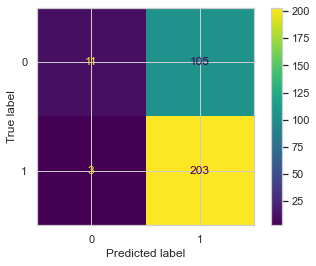

In [245]:
metrics.ConfusionMatrixDisplay.from_estimator(model, X_train, y_train)

In [248]:
##tune SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid = GridSearchCV(SVC(), param_grid,refit=True,verbose=2, n_jobs=-1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
